In [68]:
import numpy as np
import matplotlib.pyplot as plt
import astropy.table as at
import astropy.units as au

from astropy.visualization import quantity_support
quantity_support()

import matplotlib
from cycler import cycler

matplotlib.colors._colors_full_map.update({
    "custom:primary": "#b41b1b",
    "custom:secondary": "#222222"
})

CUSTOM_PLOT_STYLE = {
    "text.usetex": True,

    "font.family": "serif",
    "font.serif": ["Computer Modern Serif", *matplotlib.rcParamsDefault["font.serif"]],
    "font.size": 16,

    "mathtext.fontset": "cm",

    # Turn off the right and top spines so we don't get the "box" look
    "axes.spines.right": False,
    "axes.spines.top": False,

    # Set the default plotting color to the ones we defined above
    "axes.prop_cycle": cycler(color=("custom:primary", "custom:secondary",)),

    "axes.facecolor": "none",

    # Set some default sizes, so we don't need to include them in each call
    "lines.markersize": 5,
    "lines.linewidth": 1.5,
    "errorbar.capsize": 3,

    # Set savefig to use bbox_inches="tight" by default
    "savefig.bbox": "tight",
    "savefig.facecolor": "none"
}

matplotlib.rcdefaults()
matplotlib.rcParams.update(CUSTOM_PLOT_STYLE)

In [69]:
from astropy.io import ascii

MR_TABLE = ascii.read("M-dwarf data/Mann2015_Tables5_6_7.txt")

In [70]:
# different likelihood on https://github.com/davidwhogg/DataAnalysisRecipes/issues/18#issuecomment-305301479
def mr_likelihood_updated(params, Z, S):
    m, b = params
    v = (-m, 1)
    Sigma2 = (S @ v) @ v
    return np.sum(np.log(Sigma2) + ((Z @ v - b)**2 / Sigma2))

def mr_likelihood_updated_scatter_ortho(params, Z, S):
    m, b, V = params
    v = (-m, 1)
    Lambda = (V / (1 + m**2)) * np.outer(v, v)
    Sigma2 = ((S + Lambda) @ v) @ v
    return np.sum(np.log(Sigma2) + ((Z @ v - b)**2 / Sigma2))

def mr_likelihood_updated_scatter_y(params, Z, S):
    m, b, V = params
    v = (-m, 1)
    Sigma2 = (S @ v) @ v + V
    return np.sum(np.log(Sigma2) + ((Z @ v - b)**2 / Sigma2))

In [71]:
from scipy.optimize import minimize

Z = np.column_stack([MR_TABLE["M"], MR_TABLE["R"]])
e_cov = np.zeros_like(MR_TABLE["e_M"])

S = np.column_stack([(MR_TABLE["e_M"])**2, e_cov, e_cov, (MR_TABLE["e_R"])**2]).reshape(-1, 2, 2)

min_result = minimize(mr_likelihood_updated, (1, 0), args=(Z, S), method='L-BFGS-B', bounds=((0, 2), (-10, 10)))
min_result

  message: CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH
  success: True
   status: 0
      fun: -1225.0601063988254
        x: [ 8.606e-01  5.744e-02]
      nit: 9
      jac: [ 1.842e-03  7.526e-03]
     nfev: 36
     njev: 12
 hess_inv: <2x2 LbfgsInvHessProduct with dtype=float64>

In [72]:
from scipy.optimize import minimize

Z = np.log(np.column_stack([MR_TABLE["M"], MR_TABLE["R"]]))
e_cov = np.zeros_like(MR_TABLE["e_M"])

S = np.column_stack([(MR_TABLE["e_M"]/MR_TABLE["M"])**2, e_cov, e_cov, (MR_TABLE["e_R"]/MR_TABLE["R"])**2]).reshape(-1, 2, 2)

new_result = minimize(mr_likelihood_updated, (1, 0), args=(Z, S), method='L-BFGS-B', bounds=((0, 2), (-10, 10)))
new_result

  message: CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH
  success: True
   status: 0
      fun: -861.927842145149
        x: [ 7.786e-01 -1.829e-01]
      nit: 10
      jac: [ 0.000e+00  4.547e-05]
     nfev: 36
     njev: 12
 hess_inv: <2x2 LbfgsInvHessProduct with dtype=float64>

In [73]:
from scipy.optimize import minimize

Z = np.log(np.column_stack([MR_TABLE["M"], MR_TABLE["R"]]))
e_cov = np.zeros_like(MR_TABLE["e_M"])

S = np.column_stack([(MR_TABLE["e_M"]/MR_TABLE["M"])**2, e_cov, e_cov, (MR_TABLE["e_R"]/MR_TABLE["R"])**2]).reshape(-1, 2, 2)

scatter_result_ortho = minimize(mr_likelihood_updated_scatter_ortho, (1, 0, 0.9), args=(Z, S), method='L-BFGS-B', bounds=((0, 2), (-10, 10), (0, 1)))
scatter_result_ortho

  message: CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH
  success: True
   status: 0
      fun: -861.927842145147
        x: [ 7.786e-01 -1.829e-01  0.000e+00]
      nit: 11
      jac: [ 0.000e+00 -2.274e-05  3.237e+04]
     nfev: 112
     njev: 28
 hess_inv: <3x3 LbfgsInvHessProduct with dtype=float64>

In [74]:
scatter_result_y = minimize(mr_likelihood_updated_scatter_y, (1, 0, 0.9), args=(Z, S), method='L-BFGS-B', bounds=((0, 2), (-10, 10), (0, 1)))
scatter_result_y

  message: CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH
  success: True
   status: 0
      fun: -861.9278421322749
        x: [ 7.786e-01 -1.829e-01  0.000e+00]
      nit: 11
      jac: [-4.167e-02  3.374e-02  2.016e+04]
     nfev: 88
     njev: 22
 hess_inv: <3x3 LbfgsInvHessProduct with dtype=float64>

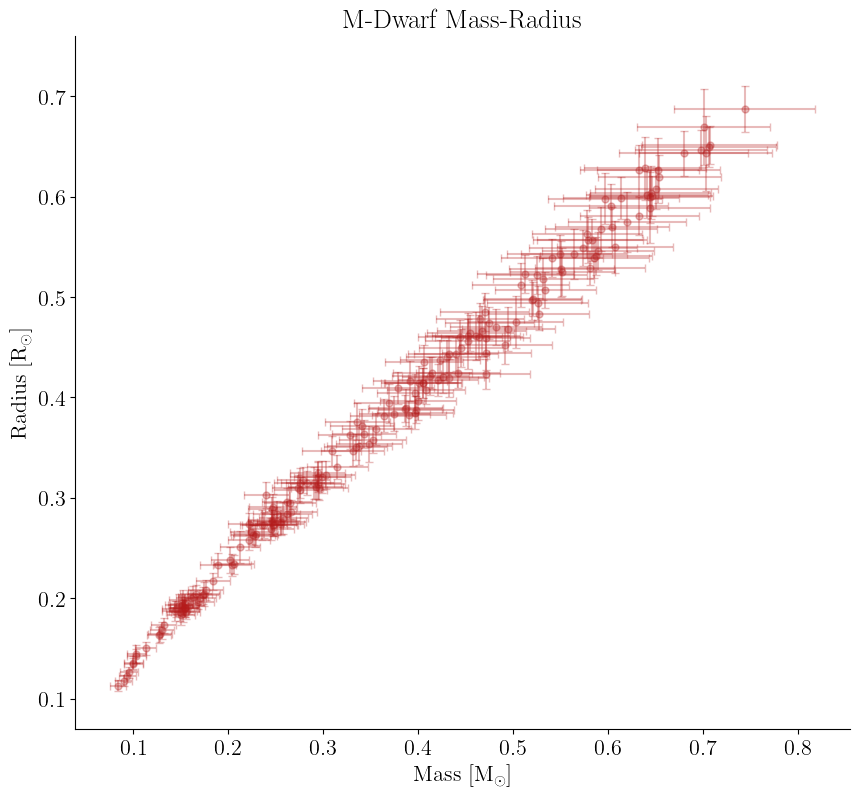

In [75]:

fig, ax = plt.subplots(figsize=(10, 9))

X = MR_TABLE["M"]
Y = MR_TABLE["R"]
e_X = MR_TABLE["e_M"]
e_Y = MR_TABLE["e_R"]

with np.errstate(invalid="ignore"):
    ax.errorbar(X, Y, fmt="o", xerr=e_X, yerr=e_Y, color="custom:primary", zorder=-10, alpha=0.3)
    xl = np.array(ax.get_xlim())

    fit_x = np.linspace(*xl, 1000)

    ax.set_ylabel("Radius [R$_\\odot$]")

    ax.set_xlabel("Mass [M$_\\odot$]")



import matplotlib.ticker as mticker

ax.yaxis.set_major_formatter(mticker.StrMethodFormatter("{x:.1f}"))
ax.yaxis.set_ticks(np.arange(0.1, 0.8, 0.1))
ax.set_ylim(0.07, 0.76)

kw = { "horizontalalignment": "right", "verticalalignment": "top", "fontsize": 22}

ax.set_title("M-Dwarf Mass-Radius")

plt.savefig("figures/MR0.png")

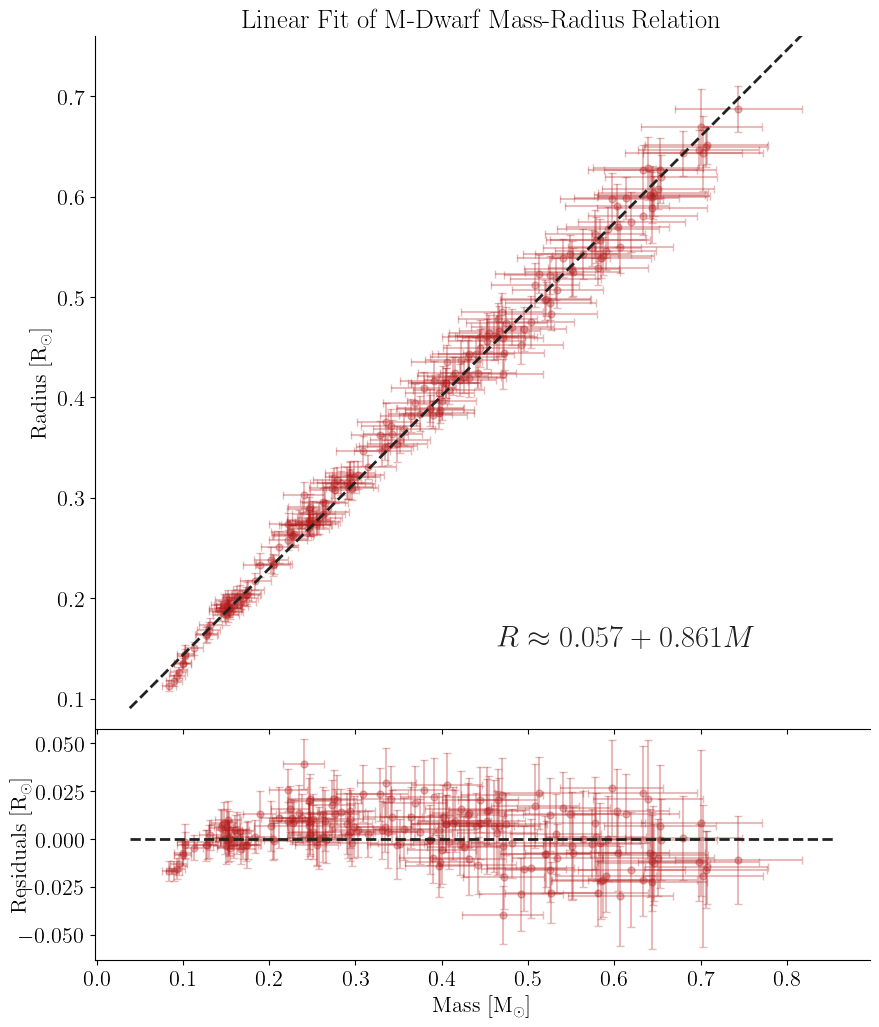

In [76]:
m, b = min_result.x

fig, (ax, ax_residuals) = plt.subplots(2, 1, sharex=True, figsize=(10, 12), height_ratios=[0.75, 0.25])
fig.subplots_adjust(hspace=0)
ax_residuals.set_zorder(-2)

X = MR_TABLE["M"]
Y = MR_TABLE["R"]
e_X = MR_TABLE["e_M"]
e_Y = MR_TABLE["e_R"]

with np.errstate(invalid="ignore"):
    ax.errorbar(X, Y, fmt="o", xerr=e_X, yerr=e_Y, color="custom:primary", zorder=-10, alpha=0.3)
    xl = np.array(ax.get_xlim())

    fit_x = np.linspace(*xl, 1000)

    ax.plot(fit_x, fit_x * m + b, "--", color="custom:secondary", linewidth=2)

    ax_residuals.errorbar(X, Y-(X * m + b), fmt="o", xerr=e_X, yerr=e_Y, zorder=-10,  alpha=0.3)
    ax_residuals.plot(fit_x, np.zeros_like(fit_x), "--", color="custom:secondary", linewidth=2)

    ax.set_ylabel("Radius [R$_\\odot$]")

    ax_residuals.set_xlabel("Mass [M$_\\odot$]")
    ax_residuals.set_ylabel("Residuals [R$_\\odot$]", labelpad=-10)



import matplotlib.ticker as mticker

ax.yaxis.set_major_formatter(mticker.StrMethodFormatter("{x:.1f}"))
ax.yaxis.set_ticks(np.arange(0.1, 0.8, 0.1))
ax.set_ylim(0.07, 0.76)

kw = { "horizontalalignment": "right", "verticalalignment": "top", "fontsize": 22}

ax.text(0.85, 0.15, f"$R \\approx {b:.3f} + {m:.3f} M$", color="custom:secondary", transform=ax.transAxes, **kw)

ax.set_title("Linear Fit of M-Dwarf Mass-Radius Relation")

plt.savefig("figures/MR1.png")

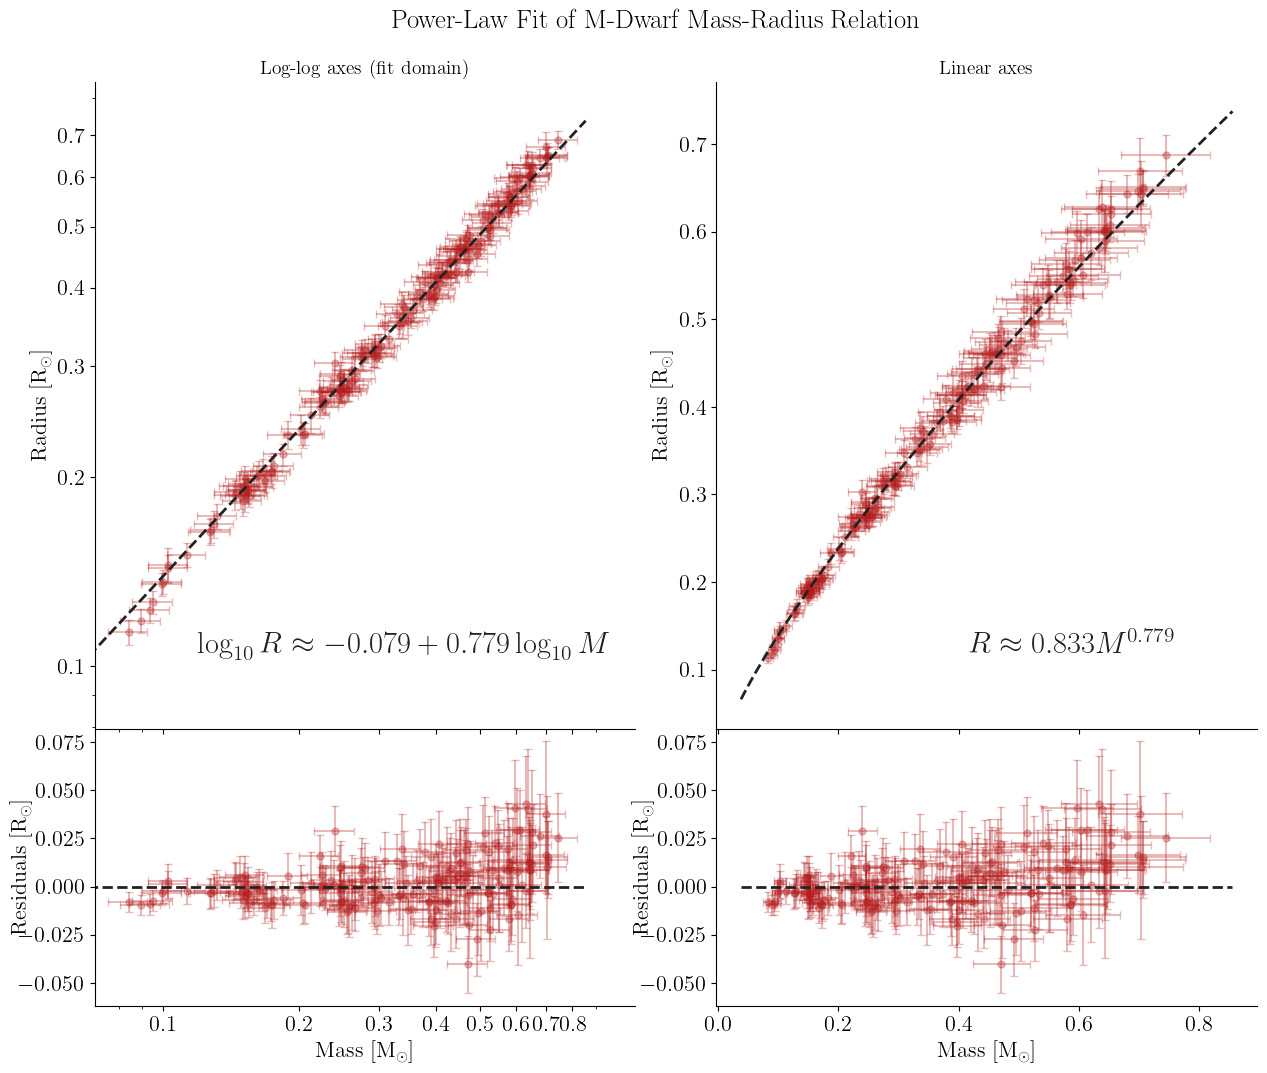

In [77]:
m, b = new_result.x

fig, axs = plt.subplots(2, 2, sharex="col", figsize=(15, 12), height_ratios=[0.7, 0.3], width_ratios=[0.5, 0.5])
fig.subplots_adjust(hspace=0, wspace=0.15)

X = MR_TABLE["M"]
Y = MR_TABLE["R"]
e_X = MR_TABLE["e_M"]
e_Y = MR_TABLE["e_R"]

for col in range(axs.shape[1]):
    ax, ax_residuals = axs[:, col]
    with np.errstate(invalid="ignore"):
        ax.errorbar(X, Y, fmt="o", xerr=e_X, yerr=e_Y, color="custom:primary", zorder=-10, alpha=0.3)
        xl = np.array(ax.get_xlim())

        fit_x = np.linspace(*xl, 1000)

        ax.plot(fit_x, np.exp(np.log(fit_x) * m + b), "--", color="custom:secondary", linewidth=2)


        ax_residuals.errorbar(X, Y-np.exp(np.log(X) * m + b), fmt="o", xerr=e_X, yerr=e_Y, zorder=-10,  alpha=0.3)
        ax_residuals.plot(fit_x, np.zeros_like(fit_x), "--", color="custom:secondary", linewidth=2)

        ax.set_ylabel("Radius [R$_\\odot$]")

        ax_residuals.set_xlabel("Mass [M$_\\odot$]")
        ax_residuals.set_ylabel("Residuals [R$_\\odot$]", labelpad=-10)

        ax_residuals.set_zorder(-1)

axs[0][0].set_xscale("log")
axs[0][0].set_xlim(10**-1.15, 1.1)



import matplotlib.ticker as mticker
axs[1][0].xaxis.set_major_formatter(mticker.StrMethodFormatter("{x:.1f}"))
axs[1][0].xaxis.set_ticks(np.arange(0.1, 0.9, 0.1))

axs[0][0].set_yscale("log")
axs[0][0].set_ylim(10**-1.1, 0.85)
axs[0][0].yaxis.set_major_formatter(mticker.StrMethodFormatter("{x:.1f}"))
axs[0][0].yaxis.set_ticks(np.arange(0.1, 0.8, 0.1))



b_10 = b / np.log(10)
C = np.exp(b)

kw = { "horizontalalignment": "right", "verticalalignment": "top", "fontsize": 22}

axs[0][0].text(0.95, 0.15, f"$\\log_{{10}} R \\approx {b_10:.3f} + {m:.3f}\\log_{{10}} M$", color="custom:secondary", transform=axs[0][0].transAxes, **kw)
axs[0][1].text(0.85, 0.15, f"$R \\approx {C:.3f} M^{{{m:.3f}}}$", color="custom:secondary", transform=axs[0][1].transAxes, **kw)

fig.suptitle("Power-Law Fit of M-Dwarf Mass-Radius Relation", y=0.94)
axs[0][0].set_title("Log-log axes (fit domain)", fontsize=14)
axs[0][1].set_title("Linear axes", fontsize=14)

plt.savefig("figures/MR2.png")

# ODR fitting using scipy

In [86]:
from scipy.odr import Model, Data, ODR

polynomial_model = Model(np.polyval)
mr_data = Data(MR_TABLE["M"], MR_TABLE["R"], wd=MR_TABLE["e_M"]**-2, we=1/MR_TABLE["e_R"]**-2)
mr_odr = ODR(mr_data, polynomial_model, beta0=[0.5, 0.5, 0.5, 0.5])
mr_odr_out = mr_odr.run()
mr_odr_out.pprint()

Beta: [ 0.52379919 -0.77079363  1.17687105  0.02782207]
Beta Std Error: [0.2352621  0.30928407 0.12596628 0.01564829]
Beta Covariance: [[ 1093296.66192218 -1426208.28150429   562646.16116786   -64247.73471104]
 [-1426208.28150429  1889509.98593025  -759875.03541462    88831.41091266]
 [  562646.16116786  -759875.03541462   313431.54764549   -37907.45882425]
 [  -64247.73471104    88831.41091266   -37907.45882425     4836.90620603]]
Residual Variance: 5.062510089093202e-08
Inverse Condition #: 0.0016589437146214898
Reason(s) for Halting:
  Sum of squares convergence


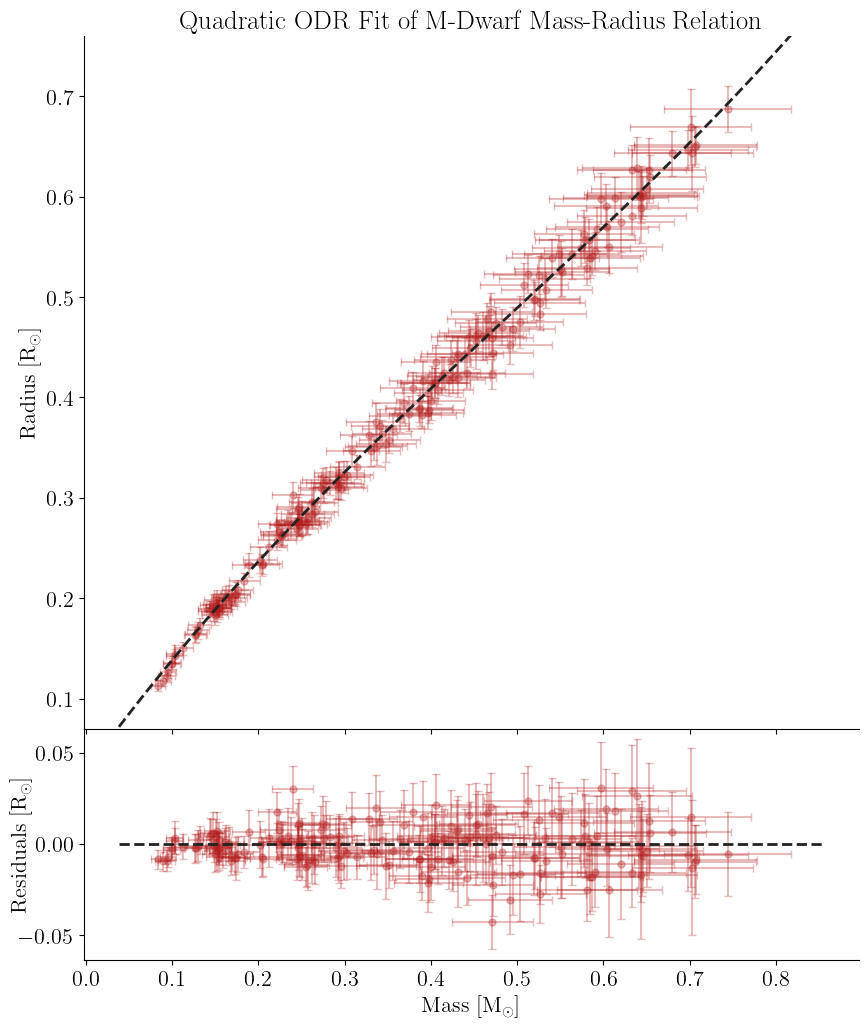

In [87]:
fig, (ax, ax_residuals) = plt.subplots(2, 1, sharex=True, figsize=(10, 12), height_ratios=[0.75, 0.25])
fig.subplots_adjust(hspace=0)
ax_residuals.set_zorder(-2)

X = MR_TABLE["M"]
Y = MR_TABLE["R"]
e_X = MR_TABLE["e_M"]
e_Y = MR_TABLE["e_R"]

with np.errstate(invalid="ignore"):
    ax.errorbar(X, Y, fmt="o", xerr=e_X, yerr=e_Y, color="custom:primary", zorder=-10, alpha=0.3)
    xl = np.array(ax.get_xlim())

    fit_x = np.linspace(*xl, 1000)

    ax.plot(fit_x, np.polyval(mr_odr_out.beta, fit_x), "--", color="custom:secondary", linewidth=2)

    ax_residuals.errorbar(X, Y-np.polyval(mr_odr_out.beta, X), fmt="o", xerr=e_X, yerr=e_Y, zorder=-10,  alpha=0.3)
    ax_residuals.plot(fit_x, np.zeros_like(fit_x), "--", color="custom:secondary", linewidth=2)

    ax.set_ylabel("Radius [R$_\\odot$]")

    ax_residuals.set_xlabel("Mass [M$_\\odot$]")
    ax_residuals.set_ylabel("Residuals [R$_\\odot$]", labelpad=-10)



import matplotlib.ticker as mticker

ax.yaxis.set_major_formatter(mticker.StrMethodFormatter("{x:.1f}"))
ax.yaxis.set_ticks(np.arange(0.1, 0.8, 0.1))
ax.set_ylim(0.07, 0.76)

kw = { "horizontalalignment": "right", "verticalalignment": "top", "fontsize": 22}

ax.set_title("Quadratic ODR Fit of M-Dwarf Mass-Radius Relation")

plt.savefig("figures/MR3.png")